---
title: "Constructing a minimal language model (Bigram/GPT)"
author: "Tommy Walsh"
date: "2024-07-02"
categories: [analysis,how_to]
format:
  html:
    code-fold: true
    code-summary: "Show the code"
    code-tools: true
    code-overflow: wrap
editor_options: 
  chunk_output_type: console
---

A minimal generatively pretrained transformer langauge model architecture. This notebook details constructing and training a transformer framework using the Tiny Shakespeare dataset.

In [60]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

## Model hyperparameters

In [61]:
batch_size = 32 # independent sequences to process in parallel
block_size = 8 # maximum context length for predictions
max_iters = 3000 # maximum number of training iterations
eval_interval = 300 # step at which to evaluate performance during training
learning_rate = 1e-2
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
eval_iters = 200

## Retrieving and examining the dataset

The code chunk below fetches the tinyshakespeare dataset that is used in this notebook and retrieves the unique characters in the dataset to construct the vocabulary for the language model.

In [62]:
#!brew install wget
#!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print("length of dataset in characters: ", len(text))

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)

length of dataset in characters:  1115394

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


## Encoding the text

The code chunk below defines mappings for each element of the vocabulary to an integer representation.

In [63]:
# create a mapping from characters to integers (character level encoding)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


This code chunk uses the mappings defined above to numerically encode the tinyshakespeare dataset and convert its datatype to a torch.tensor for work with the model.

In [64]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

## Preparing the data for training

This code chunk splits the tinyshakespeare data such that the first 90% will be used to train the model and the remainder will be used to evaluate the model.

In [65]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

This code chunk defines a function to generate batches of input and target data for the model to train or be evaluated on. Print statements are included to demonstrate the target of the model for different inputs.

In [66]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    # Create input batch x by stacking sequences of length 'block_size' starting at the indices 'ix'
    x = torch.stack([data[i:i+block_size] for i in ix])
    # Create target batch y by shifting x by one position to the right
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

# loop through batches to print target and context pairs
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([32, 8])
tensor([[ 6,  0, 21, 44,  1, 61, 43,  1],
        [58, 52, 43, 57, 57,  2,  1, 57],
        [ 1, 59, 52, 39, 41, 46, 47, 52],
        [43, 42, 50, 39, 56,  6,  1, 50],
        [59,  1, 57, 53,  1, 59, 54, 53],
        [53, 44,  0, 46, 39, 52, 45, 47],
        [59,  1, 52, 53, 58,  1, 42, 53],
        [59, 45, 45, 43, 57, 58, 43, 42],
        [46, 43, 52,  1, 41, 39, 51, 43],
        [ 1, 41, 59, 56, 43,  1, 47, 58],
        [59, 50, 50, 57, 11,  1, 39, 52],
        [39, 64, 43,  1, 53, 44,  1, 56],
        [59, 57, 58,  1, 49, 52, 53, 61],
        [ 1, 46, 47, 57,  1, 54, 39, 57],
        [ 1, 53, 58, 46, 43, 56,  1, 44],
        [ 1, 50, 39, 61,  1, 46, 53, 50],
        [42,  1, 45, 53, 53, 42, 52, 43],
        [60, 47, 57, 46,  7, 51, 39, 56],
        [58,  1, 61, 43, 56, 43,  1, 42],
        [43,  1, 45, 56, 43, 39, 58,  1],
        [39, 63, 57, 58,  1, 58, 46, 53],
        [47, 51, 43, 52, 58,  1, 61, 47],
        [47, 57, 50, 39, 52, 42,  1, 45],
      

when input is [43, 1, 45, 56, 43] the target: 39
when input is [43, 1, 45, 56, 43, 39] the target: 58
when input is [43, 1, 45, 56, 43, 39, 58] the target: 1
when input is [43, 1, 45, 56, 43, 39, 58, 1] the target: 13
when input is [39] the target: 63
when input is [39, 63] the target: 57
when input is [39, 63, 57] the target: 58
when input is [39, 63, 57, 58] the target: 1
when input is [39, 63, 57, 58, 1] the target: 58
when input is [39, 63, 57, 58, 1, 58] the target: 46
when input is [39, 63, 57, 58, 1, 58, 46] the target: 53
when input is [39, 63, 57, 58, 1, 58, 46, 53] the target: 59
when input is [47] the target: 51
when input is [47, 51] the target: 43
when input is [47, 51, 43] the target: 52
when input is [47, 51, 43, 52] the target: 58
when input is [47, 51, 43, 52, 58] the target: 1
when input is [47, 51, 43, 52, 58, 1] the target: 61
when input is [47, 51, 43, 52, 58, 1, 61] the target: 47
when input is [47, 51, 43, 52, 58, 1, 61, 47] the target: 50
when input is [47] the 

This code chunk defines a function to estimate the training and validation loss of the model without updating its parameters. The estimate_loss function temporarily sets the model to evaluation mode, computes the loss on several batches for both training and validation sets, and returns the average loss for each.

In [67]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()  # Set the model to evaluation mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)  # Initialize a tensor to store loss values
        for k in range(eval_iters):
            X, Y = get_batch(split)  # Sample a batch of data
            logits, loss = model(X, Y)  # Get logits and loss for the batch
            losses[k] = loss.item()  # Store the loss value
        out[split] = losses.mean()  # Compute the mean loss for the split
    model.train()  # Set the model back to training mode
    return out  # Return the average losses for both splits

## Construct a Bigram language model
This code chunk constructs a Bigram language model. The model is designed to predict the next token in a sequence based on the current token. The main components and steps include:
 * Bigram Language Model Class: Defines the architecture of the model, including an embedding table and methods for forward propagation and token generation.
 * Forward Method: Computes the logits for the next token and calculates the loss if targets are provided.
 * Generate Method: Generates a sequence of tokens by predicting one token at a time and appending it to the current context.
 * Model Initialization and Testing: Initializes the model, computes logits and loss for a batch of data, and generates a sample sequence of token

In [69]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        # use each tokens ebedding as the logits for the next token prediction
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size).to(device)

    def forward(self, idx, targets=None):
        # calculate cross-entropy loss of the model
        # idx and targets are both (B,T) tensor of integers
        idx = idx.to(device)
        if targets is not None:
            targets = targets.to(device)
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            # reshaping input to F.cross_entropy according to torch documentation
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        idx = idx.to(device)
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([256, 65])
tensor(4.6485, device='mps:0', grad_fn=<NllLossBackward0>)

UNasE3QKdYMjKfxcq-PyQbRF.
jxuUfZWievNL:C&v-jkcECOIiyeg zbZAcQ?yObr&MkzeAmyFXSPHd,j&?oneOAvrFotKuLTDx


## Train the model
This code chunk trains the Bigram language model using the AdamW optimizer. The training loop runs for a specified number of steps, during which it repeatedly samples batches of training data, evaluates the model's loss, and updates the model's parameters to minimize the loss. The goal is to optimize the model to predict the next token in a sequence based on the current context.

In [70]:
model = BigramLanguageModel(vocab_size)
m = model.to(device)
loss_values = []

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')
    xb, yb = xb.to(device), yb.to(device)

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

step 0: train loss 4.6162, val loss 4.6193
step 300: train loss 2.7867, val loss 2.8070
step 600: train loss 2.5457, val loss 2.5681
step 900: train loss 2.5047, val loss 2.5133
step 1200: train loss 2.4916, val loss 2.5032
step 1500: train loss 2.4728, val loss 2.4965
step 1800: train loss 2.4674, val loss 2.4934
step 2100: train loss 2.4683, val loss 2.4885
step 2400: train loss 2.4610, val loss 2.4943
step 2700: train loss 2.4542, val loss 2.4911

HEayo is mpery way avend oubur'er sickes bokecard nhiceny

He tw el fe oupise he, lbustselownthous;
I m w
T:
TIONTouly me EUSerk mondrn itheland's oe, oghithet f, badogienthofathatey foueay wad,
ureisold array n
ICoyockield, wins, in mamybalorthyongmyooe, d Vofetthindy hak shil brveseay alsteanerm to, oupomp rede d pre h, gavitfithrer'GE apsts lathindKIO:
Berouerse IOLUEDid nghathicerire.
In IS:
IOMISpequt f keithurin ne d An myorerrofe fisck.
MUCI t wovyononoru he nd youlliler pt iciHATh y onee


Plot the training loss over time.

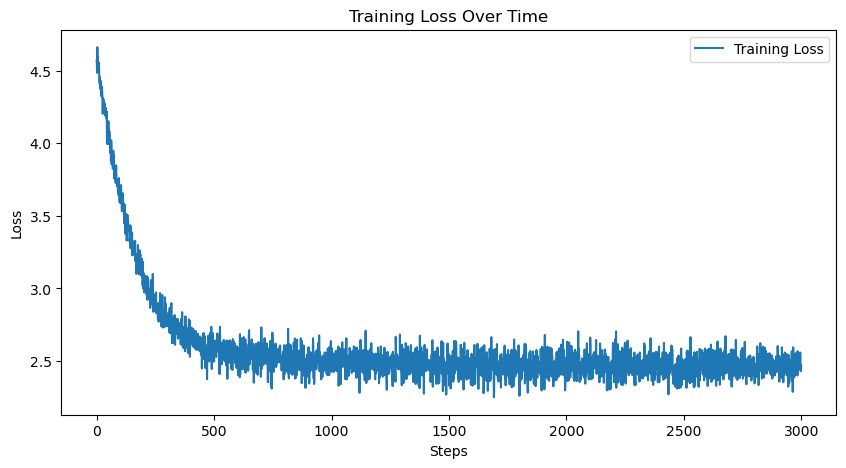

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

## Define attention blocks for a transformer model

In [75]:
batch_size = 16 # independent sequences to process in parallel
block_size = 64 # maximum context length for predictions
max_iters = 50000 # total number of training iterations
eval_interval = 500 # steps at which to evaluate on validation set
learning_rate = 1e-3 # optimizer step
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
eval_iters = 200 #number of batches to estimate loss
n_embd = 128 # dimensionality of token embeddings
n_head = 2 # numby of heads in MHA
n_layer = 2 # number of transformer layers
dropout = 0.2 # dropout probability for regularization

This code chunk defines a single head of self-attention for a multi-head attention mechanism in a transformer model. The Head class implements the necessary operations to compute the self-attention scores and apply them to the input data, including the generation of key, query, and value projections, as well as handling the attention mask to prevent attending to future positions.
 * Initialization:
     + The Head class inherits from nn.Module and represents one head of the self-attention mechanism.
     + Linear layers (nn.Linear) are used to project the input into key, query, and value vectors of size head_size. The bias=False argument indicates that no bias term is added in these linear projections.
     + A lower triangular matrix (tril) is registered as a buffer. This matrix is used to mask out future positions in the sequence to prevent attention from looking forward in time.
     + A dropout layer (nn.Dropout) is added for regularization to prevent overfitting.
 * Forward Method:
     + The forward method takes the input tensor x and computes the key (k), query (q), and value (v) projections.
     + Attention scores are computed by taking the dot product of the query and the transpose of the key, scaled by the square root of the key's dimensionality to maintain a stable gradient.
     + The attention scores are masked using the lower triangular matrix to ensure that each position can only attend to previous positions (and itself) but not future positions.
     + The masked attention scores are normalized using the softmax function to convert them into probabilities.
     + Dropout is applied to the attention weights to introduce regularization.
     + The weighted sum of the value vectors is computed using the attention weights and returned as the output.

In [30]:
class Head(nn.Module):
    """ One head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        # Linear layers to project the input to key, query, and value vectors
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        
        # Lower triangular matrix used to mask out future positions in the sequence
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Input shape: (batch_size, time_steps, channels)
        # Output shape: (batch_size, time_steps, head_size)
        
        B, T, C = x.shape
        
        # Compute key, query, and value projections
        k = self.key(x)   # Shape: (batch_size, time_steps, head_size)
        q = self.query(x) # Shape: (batch_size, time_steps, head_size)
        
        # Compute attention scores (affinities)
        wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5 # Shape: (batch_size, time_steps, time_steps)
        
        # Apply the attention mask to prevent attending to future positions
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # Shape: (batch_size, time_steps, time_steps)
        
        # Apply softmax to normalize the attention scores
        wei = F.softmax(wei, dim=-1) # Shape: (batch_size, time_steps, time_steps)
        
        # Apply dropout for regularization
        wei = self.dropout(wei)
        
        # Compute the weighted sum of the value vectors
        v = self.value(x) # Shape: (batch_size, time_steps, head_size)
        out = wei @ v # Shape: (batch_size, time_steps, time_steps) @ (batch_size, time_steps, head_size) -> (batch_size, time_steps, head_size)
        
        return out

This code chunk defines the MultiHeadAttention class, which implements multiple heads of self-attention in parallel. Each head is responsible for attending to different parts of the input sequence independently. The outputs of all the heads are concatenated and projected back to the original embedding size. This class also includes dropout for regularization.
 * Initialization:
     + The MultiHeadAttention class inherits from nn.Module and represents multiple self-attention heads working in parallel.
     + A list of Head instances is created, each representing a self-attention head. The nn.ModuleList is used to store the heads so they can be properly registered as sub-modules.
     + A linear layer (self.proj) is defined to project the concatenated outputs of all heads back to the original embedding size (n_embd).
     + A dropout layer (self.dropout) is added for regularization to prevent overfitting.
 * Forward Method:
     + The forward method takes the input tensor x and applies each self-attention head to it.
     + The outputs from all the heads are concatenated along the last dimension (dim=-1), resulting in a tensor with dimensions (batch_size, time_steps, head_size * num_heads).
     + The concatenated tensor is then projected back to the original embedding size using the linear layer, and dropout is applied for regularization.
     + The final output tensor, with dimensions (batch_size, time_steps, n_embd), is returned.

In [31]:
class MultiHeadAttention(nn.Module):
    """ Multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        # Create a list of 'Head' instances, each representing a self-attention head
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        # Linear layer to project the concatenated output of all heads back to the embedding size
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Apply each head to the input and concatenate the outputs along the last dimension
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        # Project the concatenated outputs back to the original embedding size and apply dropout
        out = self.dropout(self.proj(out))
        return out

This code chunk defines the FeedForward class, which implements a simple feedforward neural network layer used in transformer models. The layer consists of two linear transformations with a ReLU activation function in between, followed by a dropout layer for regularization.
 * Initialization:
     + The FeedForward class inherits from nn.Module and represents a feedforward neural network layer.
     + The nn.Sequential module is used to define a sequence of layers that will be applied to the input tensor x.
 * Layer Definitions:
     + nn.Linear(n_embd, 4 * n_embd): A linear layer that projects the input from its original embedding size (n_embd) to a larger size (4 * n_embd). This expansion allows the model to learn more complex representations.
     + nn.ReLU(): A ReLU (Rectified Linear Unit) activation function introduces non-linearity into the model, enabling it to learn more complex patterns.
     + nn.Linear(4 * n_embd, n_embd): A second linear layer projects the expanded representation back to the original embedding size (n_embd).
     + nn.Dropout(dropout): A dropout layer is added for regularization to prevent overfitting by randomly setting some of the input elements to zero during training.
 * Forward Method:
     + The forward method takes the input tensor x and passes it through the defined sequence of layers.
     + The final output tensor, after being processed by the feedforward network, is returned.

In [32]:
class FeedForward(nn.Module):
    """ A simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        # Define the feedforward network as a sequence of layers
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # First linear layer projects the input from n_embd to 4 * n_embd
            nn.ReLU(),                      # ReLU activation function introduces non-linearity
            nn.Linear(4 * n_embd, n_embd),  # Second linear layer projects back to n_embd
            nn.Dropout(dropout),            # Dropout layer for regularization
        )

    def forward(self, x):
        # Pass the input through the feedforward network
        return self.net(x)

This code chunk defines the Block class, which represents a single transformer block. Each block consists of multi-head self-attention followed by a feedforward neural network, with layer normalization applied before each sub-layer. Residual connections are used to help with the training of deep networks.
 * Initialization:
     + The Block class inherits from nn.Module and represents a single transformer block.
     + head_size is calculated as the embedding dimension (n_embd) divided by the number of attention heads (n_head).
     + self.sa initializes the multi-head attention mechanism using the MultiHeadAttention class.
     + self.ffwd initializes the feedforward neural network using the FeedForward class.
     + self.ln1 and self.ln2 are layer normalization layers that normalize the input before passing it to the multi-head attention and feedforward layers, respectively.
 * Forward Method:
     + The forward method takes the input tensor x and applies the following steps:
         - Layer Normalization and Multi-Head Attention: The input is first normalized using self.ln1(x), then passed through the multi-head attention mechanism (self.sa). The result is added to the original input (x) to form a residual connection.
         - Layer Normalization and Feedforward Network: The output of the previous step is normalized using self.ln2(x), then passed through the feedforward network (self.ffwd). The result is added to the input of this step to form another residual connection.
     + The final output tensor, after being processed by the transformer block, is returned.

In [33]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        # Calculate the size of each head
        head_size = n_embd // n_head
        # Multi-head attention mechanism
        self.sa = MultiHeadAttention(n_head, head_size)
        # Feedforward neural network
        self.ffwd = FeedForward(n_embd)
        # Layer normalization applied before the attention and feedforward layers
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # Apply layer normalization followed by multi-head attention, then add the residual connection
        x = x + self.sa(self.ln1(x))
        # Apply layer normalization followed by feedforward network, then add the residual connection
        x = x + self.ffwd(self.ln2(x))
        return x

## Define a GPT
This code chunk defines the GPTLanguageModel class, which represents a transformer-based language model. The model includes token and position embeddings, multiple transformer blocks, and an output layer to generate logits for the next token predictions. It also includes methods for weight initialization, forward propagation, and token generation.

 * Initialization:
     + self.token_embedding_table: Embedding layer that maps each token in the vocabulary to a dense vector of size n_embd.
     + self.position_embedding_table: Embedding layer that maps each position in the sequence to a dense vector of size n_embd.
     + self.blocks: A sequential container of Block instances, each representing a transformer block. The number of blocks is determined by n_layer.
     + self.ln_f: Final layer normalization to ensure the output is normalized before the final linear projection.
     + self.lm_head: Linear layer that projects the output of the transformer blocks to the vocabulary size, producing logits for each token.
     + Custom weight initialization is applied to ensure better training convergence.
 * Forward Method:
     + Computes token and position embeddings and sums them.
     + Passes the resulting tensor through the transformer blocks.
     + Applies layer normalization to the output of the transformer blocks.
     + Projects the output to logits using the linear layer.
     + Computes the cross-entropy loss if targets are provided. This is used during training to measure the prediction error.
 * Generate Method:
     + Generates new tokens based on the current context.
     + Iteratively appends new tokens to the context until the specified number of new tokens is generated.
     + Crops the input sequence to the last block_size tokens to ensure the model operates within its context window.
     + Computes logits and applies softmax to get probabilities for the next token.
     + Samples the next token from the probability distribution and appends it to the input sequence.

In [73]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # Token embedding table: maps each token to a dense vector
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        # Position embedding table: maps each position to a dense vector
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # Sequential container of transformer blocks
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        # Final layer normalization
        self.ln_f = nn.LayerNorm(n_embd)
        # Linear layer to project transformer outputs to vocabulary size logits
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # Apply custom weight initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        # Custom weight initialization
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        # Batch size (B) and time steps (T)
        B, T = idx.shape

        # Get token embeddings
        tok_emb = self.token_embedding_table(idx).to(device) # (B, T, C)
        # Get position embeddings
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, C)
        # Sum token and position embeddings
        x = tok_emb + pos_emb # (B, T, C)
        # Pass through transformer blocks
        x = self.blocks(x) # (B, T, C)
        # Apply final layer normalization
        x = self.ln_f(x) # (B, T, C)
        # Compute logits
        logits = self.lm_head(x) # (B, T, vocab_size)

        # Compute loss if targets are provided
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T).to(device)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # Generate new tokens given the current context
        for _ in range(max_new_tokens):
            # Crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:].to(device)
            # Get the predictions
            logits, loss = self(idx_cond)
            # Focus only on the last time step
            logits = logits[:, -1, :] # (B, C)
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # Append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

## Train the GPT model

In [76]:
# Initialize the GPT language model
model = GPTLanguageModel()
# Move the model to the appropriate device (CPU or GPU)
m = model.to(device)
# Print the number of parameters in the model (in millions)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# Create a PyTorch optimizer with AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop
for iter in range(max_iters):
    # Every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Sample a batch of training data
    xb, yb = get_batch('train')
    xb, yb = xb.to(device), yb.to(device)

    # Evaluate the model to get logits and calculate the loss
    logits, loss = model(xb, yb)
    
    # Zero the gradients to prevent accumulation
    optimizer.zero_grad(set_to_none=True)
    
    # Backpropagate the loss to compute gradients
    loss.backward()
    
    # Update the model parameters using the optimizer
    optimizer.step()

# Generate text from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_text = decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generated_text)

# Uncomment the line below to generate a longer sequence and save to 'more.txt'
# open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

0.420929 M parameters
step 0: train loss 4.2461, val loss 4.2464
step 500: train loss 2.0895, val loss 2.1367
step 1000: train loss 1.9291, val loss 2.0205
step 1500: train loss 1.8345, val loss 1.9718
step 2000: train loss 1.7796, val loss 1.9283
step 2500: train loss 1.7526, val loss 1.9263
step 3000: train loss 1.7235, val loss 1.8815
step 3500: train loss 1.7092, val loss 1.8826
step 4000: train loss 1.6787, val loss 1.8450
step 4500: train loss 1.6663, val loss 1.8363
step 5000: train loss 1.6570, val loss 1.8231
step 5500: train loss 1.6296, val loss 1.8187
step 6000: train loss 1.6309, val loss 1.8086
step 6500: train loss 1.6183, val loss 1.7991
step 7000: train loss 1.6036, val loss 1.7933
step 7500: train loss 1.6086, val loss 1.7984
step 8000: train loss 1.5887, val loss 1.7953
step 8500: train loss 1.5810, val loss 1.7810
step 9000: train loss 1.5898, val loss 1.7769
step 9500: train loss 1.5695, val loss 1.7480
step 10000: train loss 1.5683, val loss 1.7474
step 10500: tra